In [7]:
!pip install torchviz torchinfo

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.io import read_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device = ', device)

device =  cuda


In [2]:
## matplot default
plt.rcParams['font.size'] = 8
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ":"
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import cv2
import random

# Semantic segmentation (의미 분할)

In [97]:
import torchvision.transforms.functional as F

def show(imgs: list):
  if not isinstance(imgs, list):
    imgs = [imgs]

  fig, axs = plt.subplots(ncols = len(imgs), figsize = (10, 4), squeeze=False)
  for i, img in enumerate(imgs):
    img = F.to_pil_image(img)
    axs[0, i].imshow(img)
    axs[0, i].axis('off')

  plt.show()

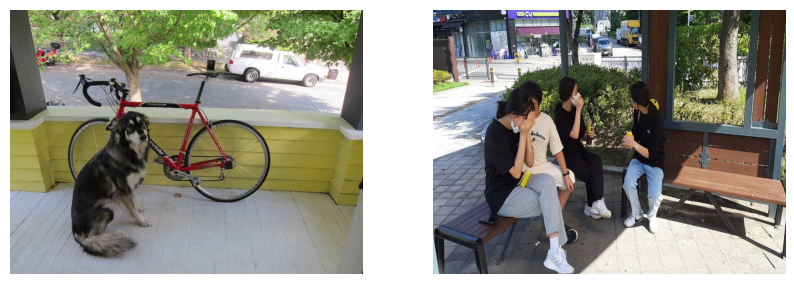

In [98]:
from torchvision.io import read_image
# from PIL import Image
data_dir = "./figures"
img1_path = os.path.join(data_dir, "dog.jpg")
img2_path = os.path.join(data_dir, "peoples.jpg")

img1 = read_image(img1_path)
img2 = read_image(img2_path)
# print("img1 shape = ", img1.shape)

img_list = [img1, img2]

# show function call
show(img_list)

pred_boxes = 
 tensor([[ 50.,  50., 100., 200.],
        [210., 150., 350., 430.]])


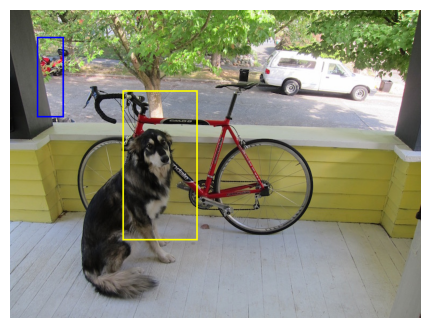

In [110]:
from torchvision.utils import draw_bounding_boxes

pred_boxes = torch.tensor([[50, 50, 100, 200],
                           [210, 150, 350, 430]]).float()
print('pred_boxes = \n', pred_boxes)
colors = ["blue", "yellow"]
labels = ["dog", "bicycle"]

result = draw_bounding_boxes(img1, pred_boxes, colors= colors, width=3)

show(result)

In [111]:
## segmantic segmentation

dir(models.segmentation)

['DeepLabV3',
 'DeepLabV3_MobileNet_V3_Large_Weights',
 'DeepLabV3_ResNet101_Weights',
 'DeepLabV3_ResNet50_Weights',
 'FCN',
 'FCN_ResNet101_Weights',
 'FCN_ResNet50_Weights',
 'LRASPP',
 'LRASPP_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'deeplabv3',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'fcn',
 'fcn_resnet101',
 'fcn_resnet50',
 'lraspp',
 'lraspp_mobilenet_v3_large']

In [152]:
weights = models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = models.segmentation.fcn_resnet50(weights = weights)
model.eval()
model = model.to(device)

print("fcn_resnet50 = ")
print(model)

fcn_resnet50 = 
FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [118]:
# img_list = [img1, img2]
preprocess = weights.transforms(resize_size=None)
batch = torch.stack([preprocess(i) for i in img_list]).to(device)
print('batch shape = ', batch.shape)

batch shape =  torch.Size([2, 3, 576, 768])


In [121]:
output = model(batch)['out']
# print(output.keys())
print(output.shape)

torch.Size([2, 21, 576, 768])


In [123]:
weights.meta["categories"]

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [124]:
## class dictionary
class_to_idx = {cls:idx for idx, cls in enumerate(weights.meta["categories"])}
print("class_to_idx = ")
display(class_to_idx)

class_to_idx = 


{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

## Class score map

In [128]:
output.shape # [2, 21,  576, 768]
output[0]

normalized_masks = torch.softmax(output, dim = 1) # [batch, num_class, height, width]
normalized_masks[1]

tensor([[[9.8052e-01, 9.8052e-01, 9.8052e-01,  ..., 9.9728e-01,
          9.9728e-01, 9.9728e-01],
         [9.8052e-01, 9.8052e-01, 9.8052e-01,  ..., 9.9728e-01,
          9.9728e-01, 9.9728e-01],
         [9.8052e-01, 9.8052e-01, 9.8052e-01,  ..., 9.9728e-01,
          9.9728e-01, 9.9728e-01],
         ...,
         [9.4709e-01, 9.4709e-01, 9.4709e-01,  ..., 9.9812e-01,
          9.9812e-01, 9.9812e-01],
         [9.4709e-01, 9.4709e-01, 9.4709e-01,  ..., 9.9812e-01,
          9.9812e-01, 9.9812e-01],
         [9.4709e-01, 9.4709e-01, 9.4709e-01,  ..., 9.9812e-01,
          9.9812e-01, 9.9812e-01]],

        [[2.6489e-04, 2.6489e-04, 2.6489e-04,  ..., 1.2725e-05,
          1.2725e-05, 1.2725e-05],
         [2.6489e-04, 2.6489e-04, 2.6489e-04,  ..., 1.2725e-05,
          1.2725e-05, 1.2725e-05],
         [2.6489e-04, 2.6489e-04, 2.6489e-04,  ..., 1.2725e-05,
          1.2725e-05, 1.2725e-05],
         ...,
         [1.2893e-04, 1.2893e-04, 1.2893e-04,  ..., 2.7905e-05,
          2.790

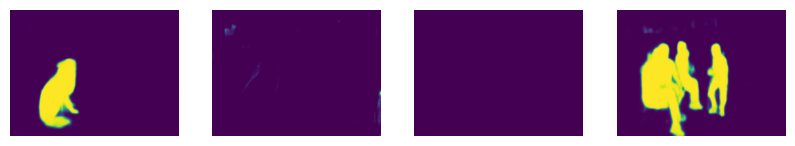

In [139]:
dog_mask = [normalized_masks[img_idx, class_to_idx[cls]]
            for img_idx in range(len(img_list))
            for cls in ["dog", "person"]]
show(dog_mask)

In [130]:
class_to_idx["dog"]

12

In [131]:
class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

In [150]:
boolean_dog_mask = normalized_masks.argmax(dim = 1) == class_to_idx["dog"]
boolean_person_mask = normalized_masks.argmax(dim = 1) == class_to_idx["person"]

boolean_dog_person_mask = (normalized_masks.argmax(dim = 1) == class_to_idx["dog"]) | \
                            (normalized_masks.argmax(dim = 1) == class_to_idx["person"])

print("boolean_dog_person_mask shape = ", boolean_dog_person_mask.shape)

boolean_dog_person_mask shape =  torch.Size([2, 576, 768])


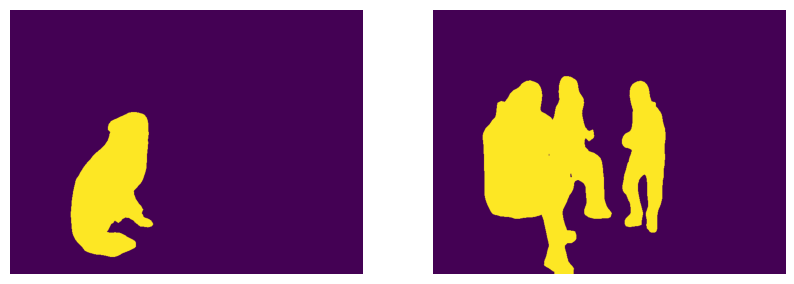

In [151]:
show([m.float() for m in boolean_dog_person_mask])

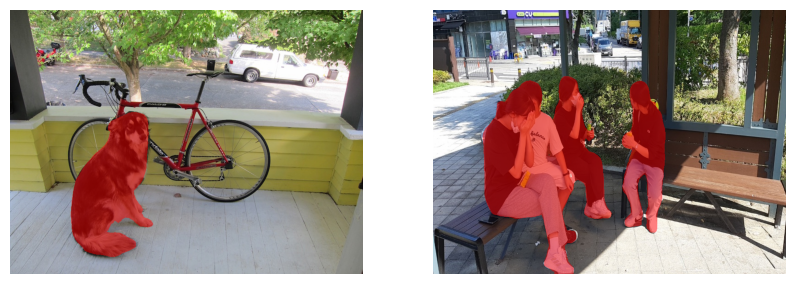

In [160]:
from torchvision.utils import draw_segmentation_masks

# dog_mask = draw_segmentation_masks(img_list[0], masks = boolean_dog_person_mask[0],
#                                    colors = "red", alpha = 0.5)
# person_mask = draw_segmentation_masks(img_list[1], masks = boolean_dog_person_mask[1],
#                                    colors = "red", alpha = 0.5)
# show([dog_mask, person_mask])

imgs_with_mask = [
    draw_segmentation_masks(img, mask, 0.5, 'red')
    for img, mask in zip(img_list, boolean_dog_person_mask)
]

show(imgs_with_mask)

# Single shot multibox detector (SSD)

In [4]:
dir(models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

In [20]:
##
weights = models.detection.SSD300_VGG16_Weights.COCO_V1 # 91
ssd300 = models.detection.ssd300_vgg16(weights=weights)

ssd300.eval()
ssd300 = ssd300.to(device)
print("ssd300 = \n", ssd300)

ssd300 = 
 SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): Re

In [8]:

from torchinfo import summary

summary(ssd300, (100, 3, 300, 300))

Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [91, 4]                   --
├─GeneralizedRCNNTransform: 1-1          [100, 3, 300, 300]        --
├─SSDFeatureExtractorVGG: 1-2            [100, 256, 1, 1]          512
│    └─Sequential: 2-1                   [100, 512, 38, 38]        --
│    │    └─Conv2d: 3-1                  [100, 64, 300, 300]       (1,792)
│    │    └─ReLU: 3-2                    [100, 64, 300, 300]       --
│    │    └─Conv2d: 3-3                  [100, 64, 300, 300]       (36,928)
│    │    └─ReLU: 3-4                    [100, 64, 300, 300]       --
│    │    └─MaxPool2d: 3-5               [100, 64, 150, 150]       --
│    │    └─Conv2d: 3-6                  [100, 128, 150, 150]      73,856
│    │    └─ReLU: 3-7                    [100, 128, 150, 150]      --
│    │    └─Conv2d: 3-8                  [100, 128, 150, 150]      147,584
│    │    └─ReLU: 3-9                    [100, 128, 150, 150]   

## voc dataet download

In [10]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

data_root = "./VOC"
dataset = datasets.VOCDetection(
    data_root,
    image_set = "val",
    download = True,
    transform = transform
)

URLError: <urlopen error [Errno 110] Connection timed out>

In [18]:
data_dir = './figures'

img_path = os.path.join(data_dir, "person.jpg")

img = read_image(img_path).unsqueeze(0).to(device) # 0 ~ 255

preprocess = weights.transforms()
img = preprocess(img) # 0 ~ 1

print("img shape = ", img.shape)

img shape =  torch.Size([1, 3, 424, 640])


In [27]:
import time

start = time.time()
prediction = ssd300(img) # 300 x 300
stop = time.time()

print(f"estimation time = {(stop - start)*1000:.4f}ms")

estimation time = 29.2339ms


In [32]:
img.shape

torch.Size([1, 3, 424, 640])

image shape =  (640, 424)
image shape =  (424, 640, 3)


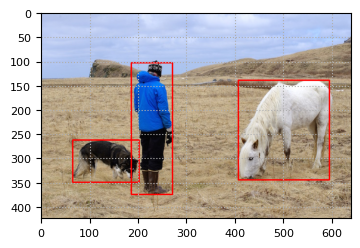

In [39]:
# prediction[0].keys()
import torchvision.transforms.functional as F
import cv2

pred_dict = prediction[0]
image = F.to_pil_image(img.squeeze().cpu())
print("image shape = ", image.size)

image = np.array(image)
# image = cv2.resize(image, (300, 300)) ## => [424, 640]
print("image shape = ", image.shape)

threshold = 0.7

for box, label, score in zip(pred_dict["boxes"], pred_dict["labels"], pred_dict["scores"]):
  if score >= threshold:
    box = list(map(int, box)) # x1, y1, x2, y2
    cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

plt.imshow(image)
plt.show()

## 얼굴 검출 (SSD)

In [40]:
## SSD + CV DNN 얼굴검출
# - https://github.com/spmallick/learnopencv/tree/master/AgeGender
import cv2

In [48]:
## tensorflow model
model = "/content/opencv_face_detector_uint8.pb"
config = "/content/opencv_face_detector.pbtxt"

filename = "/content/face/dong_face.jpg"

img = cv2.imread(filename)

# print("img shape = ", img.shape)
# print("img type = ", type(img))

## ssd face net
face_net = cv2.dnn.readNet(model, config)
##
blob = cv2.dnn.blobFromImage(img, 1, (300, 300), (104, 177, 123), swapRB = False) # preprocess
# print(blob.shape)
face_net.setInput(blob)
out = face_net.forward()

print(out.shape)

labels = ["img_id", "is_face", "confidence", "x1", "y1", "x2", "y2"]
out_df = pd.DataFrame(out[0, 0], columns=labels)
out_df.head()

(1, 1, 200, 7)


,img_id,is_face,confidence,x1,y1,x2,y2
0,0.0,1.0,0.999989,0.344201,0.159701,0.631570,0.689682
1,0.0,1.0,0.078994,0.464723,0.168216,0.579098,0.337106
2,0.0,1.0,0.078638,0.418202,0.230562,0.501073,0.330651
3,0.0,1.0,0.078233,0.405780,0.200038,0.484088,0.310276
4,0.0,1.0,0.075849,0.469298,0.350564,0.611686,0.568763


detect shape =  (200, 7)


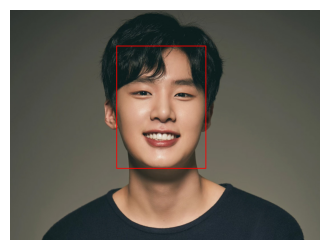

In [56]:
## face drawing

detect = out[0, 0]
print("detect shape = ", detect.shape)

h, w = img.shape[:2]

for i in range(len(detect)):
  confidence = detect[i, 2]

  if confidence > 0.5:

    x1 = int(detect[i, 3]*w)
    y1 = int(detect[i, 4]*h)
    x2 = int(detect[i, 5]*w)
    y2 = int(detect[i, 6]*h)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img1) # (r, g, b)
plt.grid(None)
plt.axis("off")
plt.show()